# ASTR302 Lab 7: Astrometry and Calibrated Photometry

In this Lab you will determine the right ascension and declination of your sources and calibrate the photometry

## Where are we?

You probably pointed the telescope at this field, or at least someone did. So you would think we would know the coordinates. However, in general the telescope pointing is not succiently precise to serve our purposes. We want to do better. 

Before we start, lets import the packages you will be needing for this Lab. You'll be using the astrometry solver which is based on the astronomy.net algorithm. 

In [1]:
#lets install the astrometry package (from astronomy.net)
!pip install --upgrade pip
!pip install astrometry

import matplotlib.pyplot as plt
import csv
import astrometry
import pandas as pd
import astropy.units as u
import numpy as np

import astropy as ap
from astropy.wcs import WCS
from astropy.io import fits

# the 'scales' in the following need to be chosen match to the estimated field-of-view (see https://pypi.org/project/astrometry/)
# these scales are the ones for the image you are working with

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={1,3},
    )
)

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


This next cell just reads in your photometry file from before and gets the list of stars that will be used by the astrometry solver.

In [2]:
# read the CSV file and make a list of coordinate pairs for astronometry solver
import re
catalog = pd.read_csv('photometry.csv')

unit = "pix"
x = [sub.replace(unit, "").strip() for sub in catalog['xcenter']]
y = [sub.replace(unit, "").strip() for sub in catalog['ycenter']]

stars = [(x[i],y[i]) for i in range(0,len(x))]

Now on to the actual solver. At the end we print out the header coordinates and the solved coordinates for comparison.

In [3]:
filename = 'imacs_image1.fits'
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header

import astrometry
import logging

logging.getLogger().setLevel(logging.INFO)

# start with values close to the what is given in the header
solution = solver.solve(
    stars=stars,
    size_hint=None,
    position_hint=astrometry.PositionHint(
        ra_deg=346.2,
        dec_deg=-8.68,
        radius_deg=1.0),
    solution_parameters=astrometry.SolutionParameters(),
)    

# defines new wcs reference frame using solved for values

if solution.has_match():
    wcs = solution.best_match().astropy_wcs()
    
# it there is a good solution check out correspondence with previous values
    print('The header RA is ',hdr['RA-D'],'and the solved RA is ',solution.best_match().center_ra_deg)
    print('The header Dec is ',hdr['DEC-D'],'and the solved Dec is ',solution.best_match().center_dec_deg)
    print('The header plate scale is ',hdr['SCALE'],'and the solved plate scale is ',solution.best_match().scale_arcsec_per_pixel)

INFO:root:solve 1: start
INFO:root:solve 1: slice=[0, 25[ (1 / 1), index="5200/index-5201-17.fits" (1 / 2)
INFO:root:solve 1: logodds=85.79, matches=10, conflicts=0, distractors=19, ra=346.224, dec=-8.68012, scale=0.110373, index="5200/index-5201-17.fits"
INFO:root:solve 1: slice=[0, 25[ (1 / 1), index="5200/index-5203-17.fits" (2 / 2)


The header RA is  346.2275417 and the solved RA is  346.22360501215275
The header Dec is  -8.7885556 and the solved Dec is  -8.6801180348188
The header plate scale is  0.111 and the solved plate scale is  0.11037277081478125


Now we will display the image, with the new coordinates, and proceed to list the coordinates of your stars. The way we will calibrate the photometry is by comparing the instrumental magnitudes you have measured for your stars with the available Sloan Digital Sky Survey values available through the Legacy Viewer (https://www.legacysurvey.org/viewer/). To keep this relatively simple, we'll do this by hand. Note that the way the image is displayed here is flipped relative to how the Viewer shows the field. You will also need to adjust the vmin and vmax values to get the best image display.

(1190.236571798087, 1190.0, 27.400498767987617)
-674.0632322955277


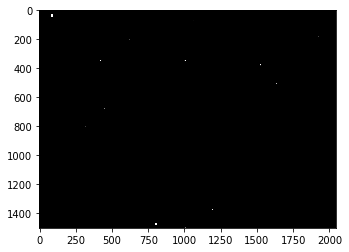

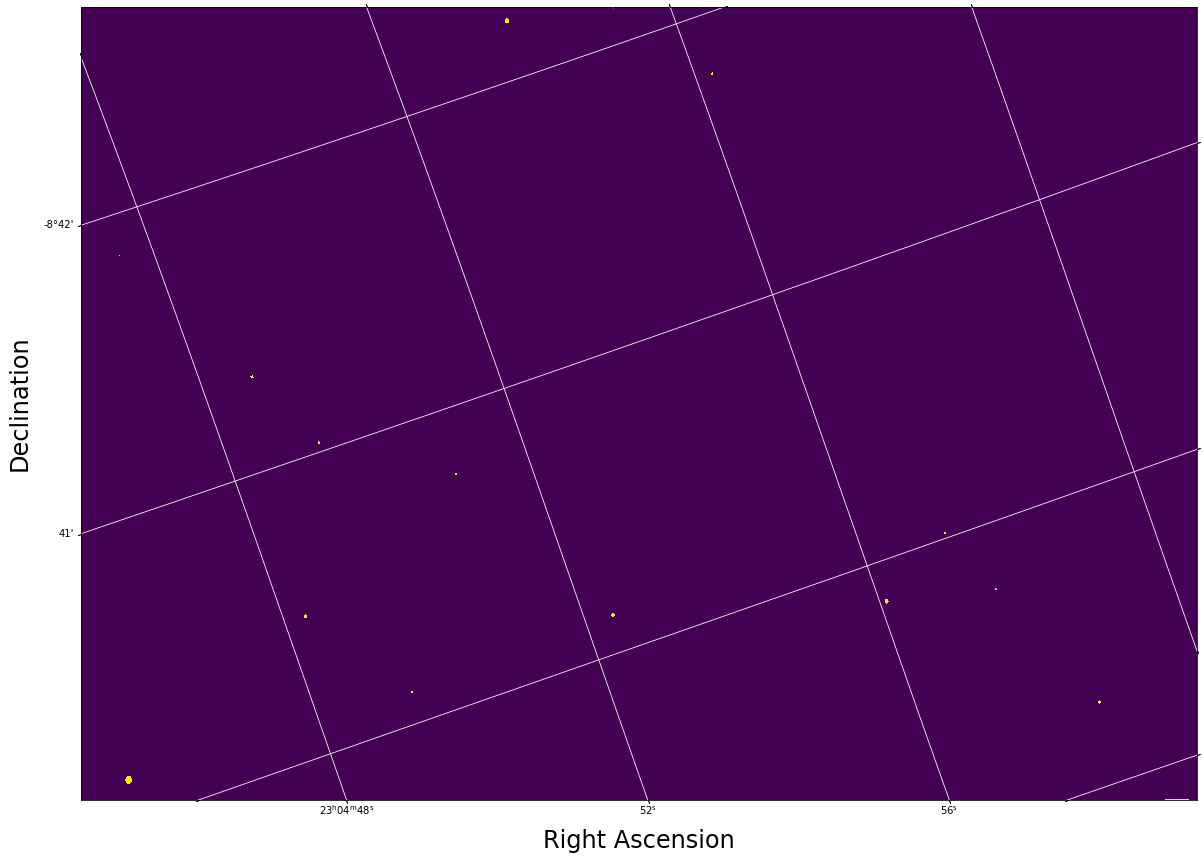

In [4]:
# define the image, open, and read the header information - use your reduced image from the previous workbook
h, w = image.shape
#overscan
overscan = []
for i in range(1,h):
    overscan = np.append(overscan,image[i, 2045:2100].mean())
#bias
bias = overscan.mean()
no_bias = image-bias
trim = no_bias[:,1:2045]

# caculate statistics of image clipping 3sigma outliers
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip
mean, median, std = sigma_clipped_stats(image, sigma=3.0)
print((mean, median, std))  

#background
from astropy import units as u
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(image, (50, 50), filter_size=(3,3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')

#image
image = image - bkg.background
final = trim - bkg.background[:,1:2045]
ax1 = plt.subplot(111)
ax1.imshow(final,cmap='gray',vmin=-100,vmax=300)
print(final.mean())

# Create the plotting object with the WCS projection.
plt.figure(figsize = (20,20))
plt.subplot(projection=wcs)
plt.imshow(image, vmin=1140, vmax=1220)
plt.grid(color='white', ls='solid', alpha=1)
plt.xlabel('Right Ascension',fontsize=24)
plt.ylabel('Declination',fontsize=24)

In [5]:
# print out the coordinates of the stars that were used for the coordinate solution

if solution.has_match():
    for star in solution.best_match().stars:
        print(f"{star.ra_deg}, {star.dec_deg}:")
        
if solution.has_match():
    wcs = solution.best_match().astropy_wcs()
    pixels = wcs.all_world2pix(
        [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
        0,
    )
print(pixels)

346.2336726615787, -8.66433147357102:
346.18823480952403, -8.66905617739931:
346.243513265095, -8.65474112509978:
346.23425808030146, -8.69655549376907:
346.2123013150077, -8.679577461529542:
346.20119195980266, -8.674652824543134:
346.23997872258013, -8.662921007300673:
346.2382475076029, -8.666945959064282:
346.2056692768748, -8.668461831367345:
346.22407622412464, -8.693401828060251:
346.21709250099656, -8.660225315520053:
346.22830047538, -8.662268106409043:
346.20532448308535, -8.683843772781202:
[[1523.05538302  373.82627979]
 [  89.03242646   35.45827201]
 [1925.74788403  183.41886924]
 [1193.04998912 1372.0966527 ]
 [ 708.13569264  615.66432135]
 [ 422.48772789  345.96295236]
 [1729.86942921  397.71755275]
 [1634.05195137  503.18319966]
 [ 625.48475843  202.26422042]
 [ 917.12691806 1166.86544041]
 [1061.99363981   70.93474562]
 [1381.67940815  253.10358231]
 [ 448.8328919   674.19480304]]


You have a choice here. You can just use the Legacy Viewer and the coordinates of these stars to get the SDSS magnitudes (use r band, but also keep the g band as we will want to look at the dependence of the calibration vs. color) to build up your photometric calibration or you can use astroquery (https://iopscience.iop.org/article/10.3847/1538-3881/aafc33) to get the magnitudes from the SIMBAD database. The latter will likely require much more effort, but will be more general if you want to make it so.

<div class="alert alert-info"> Make a plot of instrumental magnitude vs. SDSS magnitude for these stars. Perform a linear fit to get the zero point (the offset) and check for linearity. </div>

Answer: 

In [6]:
pix = catalog['aperture_sum_5']
mag = np.log10(pix)*-2.5
for i in range(len(catalog)):
    print(catalog['xcenter'][i],catalog['ycenter'][i],mag[i])
catalog['sdss'] = catalog['aperture_sum_5'] 
                                        
catalog['sdss'][0] = 16.95
catalog['sdss'][1] = 20.08
catalog['sdss'][2] = -99
catalog['sdss'][3] = 19.50        
catalog['sdss'][4] = -99
catalog['sdss'][5] = 20.53
catalog['sdss'][6] = -99
catalog['sdss'][7] = -99
catalog['sdss'][8] = 22.06
catalog['sdss'][9] = 19.26
catalog['sdss'][10] = -99
catalog['sdss'][11] = 18.94
catalog['sdss'][12] = 19.97
catalog['sdss'][13] = -99
catalog['sdss'][14] = -99
catalog['sdss'][15] = 20.38
catalog['sdss'][16] = -99
catalog['sdss'][17] = -99
catalog['sdss'][18] = 19.91
catalog['sdss'][19] = -99
catalog['sdss'][20] = -99
catalog['sdss'][21] = 20.44
catalog['sdss'][22] = -99
catalog['sdss'][23] = -99
catalog['sdss'][24] = -99
catalog['sdss'][25] = -99 
catalog['sdss'][26] = -99
catalog['sdss'][27] = 20.79
catalog['sdss'][28] = -99
catalog['sdss'][29] = -99
catalog['sdss'][30] = -99
catalog['sdss'][31] = -99
catalog['sdss'][32] = 19.77
catalog['sdss'][33] = -99 

89.96238614641645 pix 36.466999360228 pix -15.1390898029609
1063.1107727390415 pix 71.74021942179333 pix -12.12587112540396
1285.9933630197097 pix 170.7777525957898 pix -12.848537566631585
1926.763783572494 pix 184.5335228675658 pix -12.61376329291442
2021.069049015265 pix 184.67006712144297 pix -12.473397806126538
626.2026706433119 pix 203.63924493204956 pix -12.645054251509226
617.5539356589902 pix 204.9128728444667 pix -12.634879921475036
1404.2345121583983 pix 235.46503349763995 pix -11.347784440143089
1382.5725108596778 pix 254.21849886590337 pix -11.566033279195477
424.0100615554627 pix 346.64450383307366 pix -12.82394676513409
1006.4716985928205 pix 348.65261195133263 pix -12.911237683877957
1524.1041966262153 pix 374.9269748347871 pix -13.296272681130613
1730.6948679955754 pix 398.21596621002726 pix -12.25330084123961
1869.0451145647617 pix 411.1776760817167 pix -8.746860317911596
1869.5172475781524 pix 472.76390883944435 pix -10.740449740524005
1635.2225171356006 pix 504.50866

/data0/sw/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-6-3b64ed858fd3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog['sdss'][0] = 16.95
<ipython-input-6-3b64ed858fd3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog['sdss'][1] = 20.08
<ipython-input-6-3b64ed858fd3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

0    -0.476850
1     0.292180
3     0.220144
5    -0.549650
8    -0.567629
9     0.182039
11   -0.060849
12    0.243619
15   -0.466467
18    0.432989
21   -0.160525
27    0.653766
32    0.257234
dtype: float64


Text(0, 0.5, 'Instrument mag')

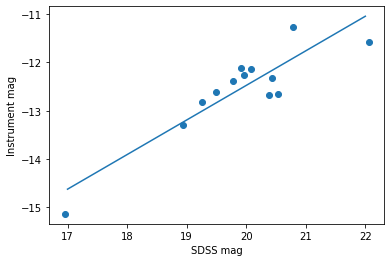

In [18]:
x = catalog['sdss']
x = x[x>-99]
y = mag[catalog['sdss']>-99]
plt.scatter(x,y)
a,b = np.polyfit(x,y,1)
xx = np.linspace(17, 22)
plt.plot(xx, a*xx+b)
offset = y-(a*x+b)
print(offset)
plt.xlabel('SDSS mag')
plt.ylabel('Instrument mag')

<div class="alert alert-info"> Now plot the offset from the fit for each star vs. color. Do you see a trend or just scatter. If there is a trend, describe the possible origin and how to address it in the calibration.</div>

In [17]:
red = [16.95, 20.08, 19.50, 20.53, 22.06, 19.26, 18.94, 19.97, 20.38, 19.91, 20.44, 20.79, 19.77]
green = [17.65, 21.25, 20.22, 21.65, 24.28, 20.30, 20.20, 20.46, 21.76, 20.19, 21.59, 21.45, 20.55]
color = []
for i in range(len(red)):
    c = green[i]-red[i]
    color.append(c)
print(color)
plt.plot(color, offset, 'o')
plt.xlabel('Color')
plt.ylabel('Offset')

According to my observation, there is a slight decrease in offset as the color values increase. I think the reason to this is because our telescope is not sensitive in every wavelength so there are a different in offset vs color. It can also possibly caused by dust as the wavelength emitted by dust will change. We can fix this by use dust elimination technique. To be honest, I don't know what that technique is, just heard it from Yu Hsiu, but I think it sounds cool so I put it here. I can fix it in a simpler way, by plotting a line of best fit to this graph, find the offset, and correct them. 

## Conclusion: 

 <div class="alert alert-info">Save your notebook.  Append your LastNameFirstInitial to the filename and submit via D2L </div>